# Modello finale

In [120]:
import util_strings as utils

In [121]:
import pickle
tfidf = True

vectorizer = pickle.load(open(utils.TfidfVectorizer if tfidf else utils.CountVectorizer, 'rb'))
football_prediction = pickle.load(open(utils.classificatorTfIdf if tfidf else utils.classificatorCV_LR, 'rb'))

Qui devo: 
* caricare il modello di football prediction, ottenere le etichette ed usarle nel dataset finale
* convertire ciascuna etichetta in 0 1 2 (verificare che non ci siano dati vuoti)
* allenare il modello su tutti i dati

In [122]:
import pandas as pd
import json
completed = pd.read_csv(utils.completed_dataset, index_col=0)
completed = completed[completed.prediction != 'NAN']

with open(utils.teams_codes, 'rb') as json_file:
    id_set = json.load(json_file)

#prendo il valore dell'ultimo id, in modo tale da assegnarlo alla prossima squadra
cont = 0
for team, id in id_set.items():
    if id == cont:
        cont+=1

import numpy as np
teams = np.append(completed.home.unique(), completed.away.unique())
teams = np.unique(teams)

In [123]:
keys = id_set.keys()
for team in teams:
    if team.lower() not in keys:
        id_set[team.lower()]=cont
        cont+=1

In [124]:
from my_tokenizer import MyTokenizer
mt = MyTokenizer(completed)
mt.feature_normalization()
mt.clean_text()
vectorized = vectorizer.transform(mt.cleaned_corpus)

In [125]:
labels = football_prediction.predict(vectorized)

Ora queste etichette le metto nel dataset completo

In [126]:
final_dataset = completed.copy()
index = 0

dict_result = {'N': 0, 'V': 1, 'P': 2}
for i, row in completed.iterrows():
    final_dataset.at[i, 'prediction'] = labels[index]
    final_dataset.at[i, 'result'] = dict_result[row.result]
    final_dataset.at[i, 'home'] = id_set[row.home]
    final_dataset.at[i, 'away'] = id_set[row.away]

    final_dataset.at[i, 'rank'] = row.rank_h-row.rank_a

    index += 1

Ora che ho ottenuto le etichette, i valori nulli li sostituisco con -1, se no perdo le partite

In [127]:
final_dataset['home'] = final_dataset['home'].astype(float)
final_dataset['away'] = final_dataset['away'].astype(float)
final_dataset['prediction'] = final_dataset['prediction'].astype(float)
final_dataset['result'] = final_dataset['result'].astype(float)

Ora che ho ottenuto il dataset come deve essere ottenuto, posso fare la classificazione secondo Decision Tree o Random Forest

Normalizzazione dei dati

In [128]:
from sklearn import preprocessing

final_dataset.drop(columns=['description', 'date', 'season','rank_h','rank_a'], inplace=True)

In [129]:
str_format = 'Tfidf' if tfidf else 'CV'
final_dataset.to_csv(utils.final_dataset.format(str_format))

In [130]:
count = 0
for d, i in final_dataset.iterrows():
    if i.result == i.prediction:
        count+=1
        
count,len(final_dataset)

(784, 1627)

In [131]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(final_dataset[[x for x in final_dataset.columns if x != 'result']], final_dataset['result'], test_size=0.2, shuffle=True) 

In [132]:
import sklearn.metrics as mtr

accuracy = 0
min_acc = 0.58
#min_acc = 0.52
while(accuracy < min_acc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    analysis = pd.DataFrame()
            
    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    if accuracy < report['accuracy']:
        accuracy = report['accuracy']
        print(accuracy)

analysis = {
        'Model': 'DecisionTree', 'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    }

0.558282208588957
0.5674846625766872
0.5705521472392638
0.5766871165644172
0.5828220858895705


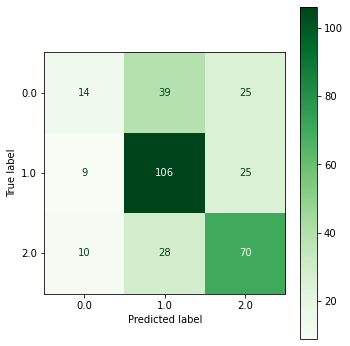

In [133]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

cm = mtr.confusion_matrix(y_test, y_pred)
d = mtr.ConfusionMatrixDisplay(cm, model.classes_)
fig, ax = plt.subplots(figsize=(5,5))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [134]:
import pickle

classificator = utils.final_classificator_Tfidf if tfidf else utils.final_classificator_CV
with open(classificator, 'wb') as file:
    pickle.dump(model, file)